# Quickstart

`pyTDGL` solves a generalized time-depdendent Ginzburg-Landau (TDGL) equation for two-dimensional superconducting *device* with arbitrary geometry. At a high level, the TDGL model can be understood as a set of coupled partial differential equations (PDEs) describing the evolution of a complex field $\psi(\mathbf{r}, t)$ (the superconducting order parameter) and $\mu(\mathbf{r}, t)$ (the electric potential) in space and time.

The inputs to the model are:

1. Properties of the superconducting thin film: thickness $d$, Ginzburg-Landau coherence length $\xi$, and London penetration depth $\lambda$ (see `tdgl.Layer`).
2. The geometry of the device residing in the film, which can include holes (see `tdgl.Polygon`).
3. A time-independent applied magnetic vector potential $\mathbf{A}_\mathrm{applied}(\mathbf{r})$.
4. An applied bias current $I_\mathrm{source-drain}$, which flows into the device through a *source terminal* and out of the device through a *drain terminal*.

The outputs of the model are:

1. The complex order parameter $\psi(\mathbf{r}, t)=|\psi|e^{i\theta}$, where $|\psi|^2=n_s$ is the normalized superfluid density.
2. The electric scalar potential $\mu(\mathbf{r}, t)$, which arises from motion of vortices in the film.
3. The sheet current density in the device, $\mathbf{K}(\mathbf{r}, t)=\mathbf{K}_s(\mathbf{r}, t)+\mathbf{K}_n(\mathbf{r}, t)$, which is the sum of the sheet supercurrent density $\mathbf{K}_s$ and the sheet normal current density $\mathbf{K}_n$.

While the TDGL calculation is performed in dimensionless units, the inputs and outputs are specified in experimentalist-friendly physics units. The translation between the two is handled by the `tdgl.Device` class.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import shutil

import matplotlib.pyplot as plt
import numpy as np

import tdgl
from tdgl.geometry import box, circle

In [2]:
os.makedirs("data", exist_ok=True)

## Superconducting weak link

In [3]:
length_units = "um"
xi = 0.5
london_lambda = 2
d = 0.1

total_width = 5
total_length = 2.5 * total_width
link_width = total_width / 5

layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d)
film = tdgl.Polygon("film", points=box(total_length, total_width))
notch = (
    tdgl.Polygon(points=box(total_width))
    .rotate(45)
    .translate(dy=(np.sqrt(2) * total_width + link_width) / 2)
)
film = film.difference(notch, notch.scale(yfact=-1))
source = tdgl.Polygon(
    points=box(total_length / 100, 1.1 * total_width, center=(-total_length / 2, 0))
)
drain = source.scale(xfact=-1)
voltage_points = [(-total_length / 3, 0), (total_length / 3, 0)]

In [4]:
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    source_terminal=source,
    drain_terminal=drain,
    voltage_points=voltage_points,
    length_units=length_units,
)

In [5]:
device.mesh_stats_dict()

{'num_sites': None,
 'num_elements': None,
 'min_edge_length': None,
 'max_edge_length': None,
 'mean_edge_length': None,
 'min_area': None,
 'max_area': None,
 'mean_area': None,
 'coherence_length': 0.5,
 'length_units': 'um'}

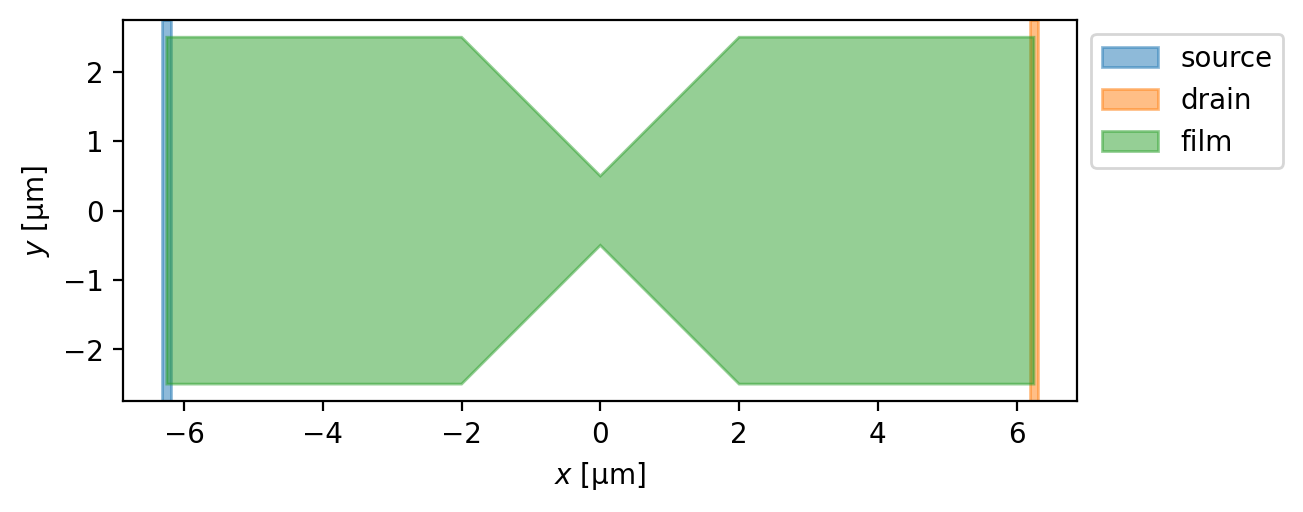

In [6]:
fig, ax = device.draw()

In [7]:
device.make_mesh(min_points=2000, max_edge_length=xi / 2, optimesh_steps=40)

In [8]:
device.mesh_stats()

num_sites,6526
num_elements,12737
min_edge_length,0.0668
max_edge_length,0.2083
mean_edge_length,0.1006
min_area,0.0023
max_area,0.0366
mean_area,0.0085
coherence_length,0.5000
length_units,um


In [ ]:
fig, ax = device.plot(mesh=True)

In [ ]:
prec = 2
test = 3.0004

In [ ]:
f"{test:.{prec}f}"

In [ ]:
dt = 1e-3
total_time = 100

options = tdgl.SolverOptions(
    dt_min=dt,
    dt_max=10 * dt,
    skip_time=100,
    total_time=50,
    save_every=100,
)

In [ ]:
solution = tdgl.solve(
    device,
    "data/weak-link.h5",
    options,
    applied_vector_potential=tdgl.sources.constant.ConstantField(0),
    field_units="uT",
    gamma=10,
    source_drain_current=10,
    current_units="uA",
    include_screening=False,
)

In [ ]:
fig, ax = plt.subplots()
ax.plot(solution.dynamics.time, solution.dynamics.voltage)
ax.axhline(solution.dynamics.mean_voltage(), color="C1", label="Mean voltage")
ax.set_xlabel("Time, $t/\\tau$")
ax.set_ylabel("Voltage, $V/V_0$")
ax.legend(loc=1)

In [ ]:
solution.plot_scalar_potential()

In [ ]:
solution.plot_order_parameter()

In [ ]:
from tdgl.visualization import animate

In [ ]:
animate.MultiAnimate(
    solution.path,
    solution.path.replace(".h5", ".gif"),
    fps=15,
    dpi=400,
    observables=("complex_field", "scalar_potential", "normal_current", "supercurrent"),
    max_cols=2,
    quiver=False,
    full_title=False,
    figure_kwargs=dict(figsize=(6, 3)),
).build()

Animation:

![gif](data/weak-link.gif)

In [ ]:
fig, ax = plt.subplots()
ax.plot(solution.dynamics.time, solution.dynamics.voltage)
ax.axhline(solution.dynamics.mean_voltage(), color="C1", label="Mean voltage")
ax.set_xlabel("Time, $t/\\tau$")
ax.set_ylabel("Voltage, $V/V_0$")
ax.legend(loc=1)